In [59]:
import numpy as np
from math import sin, pi
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d
ie = 60
je = 60
ic = int(ie / 2 - 5)
jc = int(je / 2 - 5)
ez = np.zeros((ie, je))
dz = np.zeros((ie, je))
hx = np.zeros((ie, je))
hy = np.zeros((ie, je))
ihx = np.zeros((ie, je))
ihy = np.zeros((ie, je))
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
# Create Dielectric Profile
epsz = 8.854e-12
# Pulse Parameters
t0 = 40
spread = 12
gaz = np.ones((ie, je))
# Calculate the PML parameters
gi2 = np.ones(ie)
gi3 = np.ones(ie)
fi1 = np.zeros(ie)
fi2 = np.ones(ie)
fi3 = np.ones(ie)
gj2 = np.ones(ie)
gj3 = np.ones(ie)
fj1 = np.zeros(ie)
fj2 = np.ones(ie)
fj3 = np.ones(ie)
npml = 8
for n in range(npml):
    xnum = npml - n
    xd = npml
    xxn = xnum / xd
    xn = 0.33 * xxn ** 3
    gi2[n] = 1 / (1 + xn)
    gi2[ie - 1 - n] = 1 / (1 + xn)
    gi3[n] = (1 - xn) / (1 + xn)
    gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
    gj2[n] = 1 / (1 + xn)
    gj2[je - 1 - n] = 1 / (1 + xn)
    gj3[n] = (1 - xn) / (1 + xn)
    gj3[je - 1 - n] = (1 - xn) / (1 + xn)
    xxn = (xnum - 0.5) / xd
    xn = 0.33 * xxn ** 3
    fi1[n] = xn
    fi1[ie - 2 - n] = xn
    fi2[n] = 1 / (1 + xn)
    fi2[ie - 2 - n] = 1 / (1 + xn)
    fi3[n] = (1 - xn) / (1 + xn)
    fi3[ie - 2 - n] = (1 - xn) / (1 + xn)
    fj1[n] = xn
    fj1[je - 2 - n] = xn
    fj2[n] = 1 / (1 + xn)
    fj2[je - 2 - n] = 1 / (1 + xn)
    fj3[n] = (1 - xn) / (1 + xn)
    fj3[je - 2 - n] = (1 - xn) / (1 + xn)
nsteps = 100
# Dictionary to keep track of desired points for plotting
plotting_points = [
{'num_steps': 40, 'data_to_plot': None},
{'num_steps': nsteps, 'data_to_plot': None},
]
# Main FDTD Loop
neural_x = []
neural_y = []
for time_step in range(1, nsteps + 1):
    # Calculate Dz
    for j in range(1, je):
        for i in range(1, ie):
            if j > je - 6 or i > je - 6 or j < 6 or i < 6:
                    neural_x.append(dz[i, j] + 0.5 * (hy[i, j] - hy[i - 1, j] - hx[i, j] + hx[i, j - 1]))
                    neural_y.append(gi3[i] * gj3[j] * dz[i, j] + gi2[i] * gj2[j] * 0.5 * (hy[i, j] - hy[i - 1, j] - hx[i, j] + hx[i, j - 1]))
            dz[i, j] = gi3[i] * gj3[j] * dz[i, j] + \
            gi2[i] * gj2[j] * 0.5 * \
            (hy[i, j] - hy[i - 1, j] -
            hx[i, j] + hx[i, j - 1])
    # Put a Gaussian pulse in the middle
    pulse = sin(2 * pi * 1500 * 1e6 * dt * time_step)
    dz[ic, jc] = pulse
    ez = gaz * dz # Calculate the Ez field from Dz
    # Calculate the Hx field
    for j in range(je - 1):
        for i in range(ie - 1):
            curl_e = ez[i, j] - ez[i, j + 1]
            ihx[i, j] = ihx[i, j] + curl_e
            hx[i, j] = fj3[j] * hx[i, j] + fj2[j] * \
            (0.5 * curl_e + fi1[i] * ihx[i, j])
    for j in range(0, je - 1):
        for i in range(0, ie - 1):
            curl_e = ez[i, j] - ez[i + 1, j]
            ihy[i, j] = ihy[i, j] + curl_e
            hy[i, j] = fi3[i] * hy[i, j] - fi2[i] * \
            (0.5 * curl_e + fj1[j] * ihy[i, j])
        # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['data_to_plot'] = np.copy(ez)

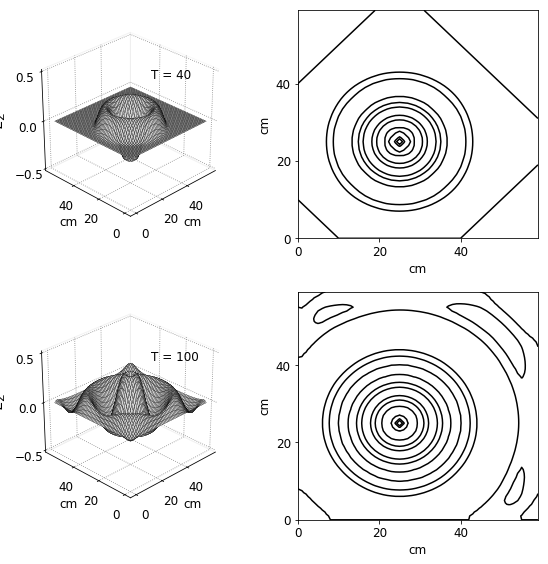

In [60]:
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 8))
X, Y = np.meshgrid(range(je), range(ie))
def plot_e_field(ax, data, timestep):
    """3d Plot of E field at a single time step"""
    ax.set_zlim(-0.5, 0.5)
    ax.view_init(elev=30., azim=-135)
    ax.plot_surface(X, Y, data, rstride=1, cstride=1,
    color='white',
    edgecolor='black', linewidth=.25)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10,
    fontsize=14)
    ax.set_xlabel('cm')
    ax.set_ylabel('cm')
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    ax.set_zticks([-0.5, 0, 0.5])
    ax.text2D(0.6, 0.7, "T = {}".format(timestep),
    transform=ax.transAxes)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = \
    ax.zaxis.pane.fill = False
    plt.gca().patch.set_facecolor('white')
    ax.dist = 11
def plot_e_field_contour(ax, data):
    """Contour Plot of E field at a single time step"""
    CP = plt.contour(X, Y, data, colors='black',
    linestyles='solid')
    CP.collections[4].remove()
# above removes extraneous outer contour display
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    plt.xlabel('cm')
    plt.ylabel('cm')
# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 1,
    projection='3d')
    plot_e_field(ax, plotting_point['data_to_plot'],
    plotting_point['num_steps'])
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 2)
    plot_e_field_contour(ax, plotting_point['data_to_plot'])
plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.show()

In [61]:
fi2

array([0.78621815, 0.8496145 , 0.90315155, 0.94452528, 0.97310884,
       0.99002961, 0.99782943, 0.99991944, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99991944, 0.99782943, 0.99002961, 0.97310884,
       0.94452528, 0.90315155, 0.8496145 , 0.78621815, 1.        ])

In [62]:
neural_xn = []
neural_yn = []
for i in range(len(neural_x)):
    if neural_x[i] != neural_y[i]:
        neural_xn.append(neural_x[i])
        neural_yn.append(neural_y[i])
neural_x, neural_y = neural_xn, neural_yn
len(neural_x)

63608

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [64]:
model = Sequential()
#model.add(Dense(16, input_dim=1, activation="linear"))
model.add(Dense(1024,input_dim=1, activation="linear"))
model.add(Dropout(5))
model.add(Dense(1, activation="linear"))

In [65]:
model.compile(optimizer="sgd",loss="mean_squared_error",metrics=["mean_squared_error"])
history = model.fit(neural_x, neural_y, epochs=10, batch_size=8)

Epoch 1/10
63608/63608 [==============================] - 8s 132us/step - loss: 4.3443e-04 - mean_squared_error: 4.3443e-04
Epoch 2/10
63608/63608 [==============================] - 8s 125us/step - loss: 2.4279e-05 - mean_squared_error: 2.4279e-05
Epoch 3/10
63608/63608 [==============================] - 8s 122us/step - loss: 1.6883e-05 - mean_squared_error: 1.6883e-05
Epoch 4/10
63608/63608 [==============================] - 8s 127us/step - loss: 1.6762e-05 - mean_squared_error: 1.6762e-05
Epoch 5/10
63608/63608 [==============================] - 8s 131us/step - loss: 1.6761e-05 - mean_squared_error: 1.6761e-05
Epoch 6/10
63608/63608 [==============================] - 8s 128us/step - loss: 1.6754e-05 - mean_squared_error: 1.6754e-05
Epoch 7/10
63608/63608 [==============================] - 8s 129us/step - loss: 1.6765e-05 - mean_squared_error: 1.6765e-05
Epoch 8/10
63608/63608 [==============================] - 8s 128us/step - loss: 1.6760e-05 - mean_squared_error: 1.6760e-05
Epoch 9/

In [66]:
predicted = model.predict(neural_x)

In [67]:
def visualize_predictions(x, y_true, y_pred):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, c="b", label="Valores da PML")
    ax.plot(x, y_pred, c="r", label="Valores preditos")
    ax.legend()
    
    plt.show()

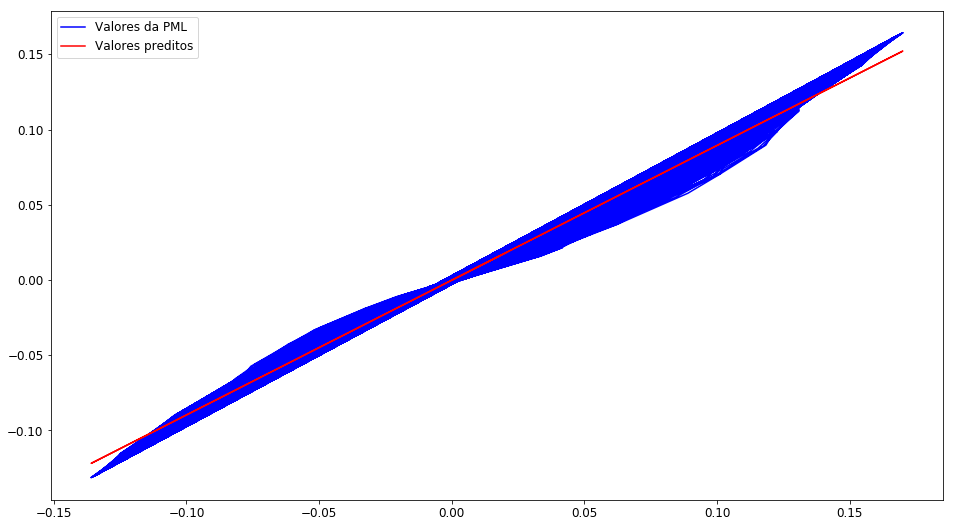

In [68]:
visualize_predictions(neural_x, neural_y, predicted)

In [69]:
import numpy as np
from math import sin, pi
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d
ie = 60
je = 60
ic = int(ie / 2 - 5)
jc = int(je / 2 - 5)
ez = np.zeros((ie, je))
dz = np.zeros((ie, je))
hx = np.zeros((ie, je))
hy = np.zeros((ie, je))
ihx = np.zeros((ie, je))
ihy = np.zeros((ie, je))
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
# Create Dielectric Profile
epsz = 8.854e-12
# Pulse Parameters
t0 = 40
spread = 12
gaz = np.ones((ie, je))
# Calculate the PML parameters
gi2 = np.ones(ie)
gi3 = np.ones(ie)
fi1 = np.zeros(ie)
fi2 = np.ones(ie)
fi3 = np.ones(ie)
gj2 = np.ones(ie)
gj3 = np.ones(ie)
fj1 = np.zeros(ie)
fj2 = np.ones(ie)
fj3 = np.ones(ie)
npml = 8
for n in range(npml):
    xnum = npml - n
    xd = npml
    xxn = xnum / xd
    xn = 0.33 * xxn ** 3
    gi2[n] = 1 / (1 + xn)
    gi2[ie - 1 - n] = 1 / (1 + xn)
    gi3[n] = (1 - xn) / (1 + xn)
    gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
    gj2[n] = 1 / (1 + xn)
    gj2[je - 1 - n] = 1 / (1 + xn)
    gj3[n] = (1 - xn) / (1 + xn)
    gj3[je - 1 - n] = (1 - xn) / (1 + xn)
    xxn = (xnum - 0.5) / xd
    xn = 0.33 * xxn ** 3
    fi1[n] = xn
    fi1[ie - 2 - n] = xn
    fi2[n] = 1 / (1 + xn)
    fi2[ie - 2 - n] = 1 / (1 + xn)
    fi3[n] = (1 - xn) / (1 + xn)
    fi3[ie - 2 - n] = (1 - xn) / (1 + xn)
    fj1[n] = xn
    fj1[je - 2 - n] = xn
    fj2[n] = 1 / (1 + xn)
    fj2[je - 2 - n] = 1 / (1 + xn)
    fj3[n] = (1 - xn) / (1 + xn)
    fj3[je - 2 - n] = (1 - xn) / (1 + xn)
nsteps = 100
# Dictionary to keep track of desired points for plotting
plotting_points = [
{'num_steps': 40, 'data_to_plot': None},
{'num_steps': nsteps, 'data_to_plot': None},
]
# Main FDTD Loop
neural_x = []
neural_y = []
for time_step in range(1, nsteps + 1):
    # Calculate Dz
    for j in range(1, je):
        for i in range(1, ie):
            if j < 2 or j > je - 2 or i < 2 or i > je - 2:
                    dz[i, j] = model.predict([dz[i, j]])[0][0]
            else:
                dz[i, j] =  dz[i, j] + \
            gi2[i] * gj2[j] * 0.5 * \
            (hy[i, j] - hy[i - 1, j] -
            hx[i, j] + hx[i, j - 1])
    # Put a Gaussian pulse in the middle
    pulse = sin(2 * pi * 1500 * 1e6 * dt * time_step)
    dz[ic, jc] = pulse
    ez = gaz * dz # Calculate the Ez field from Dz
    # Calculate the Hx field
    for j in range(je - 1):
        for i in range(ie - 1):
            curl_e = ez[i, j] - ez[i, j + 1]
            ihx[i, j] = ihx[i, j] + curl_e
            hx[i, j] = fj3[j] * hx[i, j] + fj2[j] * \
            (0.5 * curl_e + fi1[i] * ihx[i, j])
    for j in range(0, je - 1):
        for i in range(0, ie - 1):
            curl_e = ez[i, j] - ez[i + 1, j]
            ihy[i, j] = ihy[i, j] + curl_e
            hy[i, j] = fi3[i] * hy[i, j] - fi2[i] * \
            (0.5 * curl_e + fj1[j] * ihy[i, j])
        # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['data_to_plot'] = np.copy(ez)

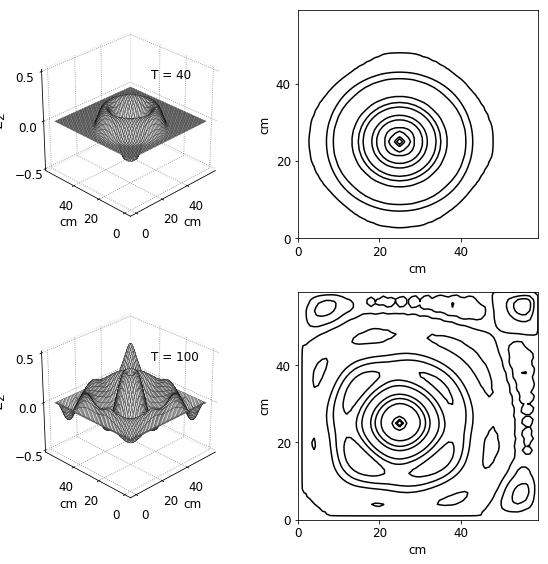

In [70]:
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 8))
X, Y = np.meshgrid(range(je), range(ie))
def plot_e_field(ax, data, timestep):
    """3d Plot of E field at a single time step"""
    ax.set_zlim(-0.5, 0.5)
    ax.view_init(elev=30., azim=-135)
    ax.plot_surface(X, Y, data, rstride=1, cstride=1,
    color='white',
    edgecolor='black', linewidth=.25)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10,
    fontsize=14)
    ax.set_xlabel('cm')
    ax.set_ylabel('cm')
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    ax.set_zticks([-0.5, 0, 0.5])
    ax.text2D(0.6, 0.7, "T = {}".format(timestep),
    transform=ax.transAxes)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = \
    ax.zaxis.pane.fill = False
    plt.gca().patch.set_facecolor('white')
    ax.dist = 11
def plot_e_field_contour(ax, data):
    """Contour Plot of E field at a single time step"""
    CP = plt.contour(X, Y, data, colors='black',
    linestyles='solid')
    CP.collections[4].remove()
# above removes extraneous outer contour display
    ax.set_xticks(np.arange(0, 60, step=20))
    ax.set_yticks(np.arange(0, 60, step=20))
    plt.xlabel('cm')
    plt.ylabel('cm')
# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 1,
    projection='3d')
    plot_e_field(ax, plotting_point['data_to_plot'],
    plotting_point['num_steps'])
    ax = fig.add_subplot(2, 2, subplot_num * 2 + 2)
    plot_e_field_contour(ax, plotting_point['data_to_plot'])
plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.show()

In [71]:
model.save('pml-IA')

In [72]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, title="")